## Definindo o Problema

In [1]:
#!pip install lightgbm;
#!pip install pymoo;
#!pip install -U pyrecorder;

In [2]:
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix
import numpy as np
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
#from google.colab import drive
import pickle
from pymoo.algorithms.soo.nonconvex.pso import PSO, PSOAnimation
#from pymoo.factory import Rastrigin
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
from pymoo.factory import get_termination
#from pymoo.util.display import Display
from pymoo.core.callback import Callback

In [3]:
import lightgbm as lgb

In [4]:
#drive.mount('/content/gdrive')

In [5]:
#with open('/content/gdrive/MyDrive/datasets/credit.pkl', 'rb') as f:
#    x_fruit_train, x_fruit_test, y_fruit_train, y_fruit_test = pickle.load(f)
    
#with open('./fruit.pkl', 'rb') as f:
#    x_fruit, y_fruit = pickle.load(f)
    
with open('./fruit.pkl', 'rb') as f:
    x_fruit, y_fruit = pickle.load(f)

Definindo as restrições 

In [6]:
OBJECTIVE = ['Accuracy']
DIMENSIONS = 25 #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, subsample, reg_alpha, reg_lambda
ITERATIONS = 10
POPULATION = 15
num_leaves_min = 10
num_leaves_max = 200
min_child_samples_min = 10
min_child_samples_max = 50
n_estimators_min = 20
n_estimators_max = 1000

learning_rate_min = 0.001
learning_rate_max = 0.5
subsample_for_bin_min = 50000
subsample_for_bin_max = 500000
min_split_gain_min = 0.01
min_split_gain_max = 0.5
min_child_weight_min = 0.001
min_child_weight_max = 0.15
subsample_min = 1.0
subsample_max = 2.0
reg_alpha_min =0.01
reg_alpha_max = 100.0 
reg_lambda_min = 0.01
reg_lambda_max = 100.0

BOUNDS = []
SEED = 1
INDIVIDUALS = []

https://lightgbm.readthedocs.io/en/latest/Parameters.html#force_col_wise

parameters

In [7]:
max_depth_min = 1
bagging_fraction_min = 0.0
pos_bagging_fraction_min = 0.0
neg_bagging_fraction_min = 0.0
bagging_freq_min = 0
feature_fraction_min = 0.0
feature_fraction_bynode_min = 0.0
extra_trees_min = 0 # boolean
first_metric_only_min = 0 # boolean
max_delta_step_min = -10.0
linear_lambda_min = 0.0
min_data_per_group_min = 1
max_cat_threshold_min = 1
cat_l2_min = 0.0
cat_smooth_min = 0.0
max_cat_to_onehot_min = 1
top_k_min = 1

max_depth_max = 50 #int
bagging_fraction_max = 1.0
pos_bagging_fraction_max = 1.0
neg_bagging_fraction_max = 1.0
bagging_freq_max = 100 #int
feature_fraction_max = 1.0
feature_fraction_bynode_max = 1.0
extra_trees_max = 1 # boolean
first_metric_only_max = 1 # boolean
max_delta_step_max = 10.0
linear_lambda_max = 10.0
min_data_per_group_max = 200 #int
max_cat_threshold_max = 100 #int
cat_l2_max = 20.0
cat_smooth_max = 20.0
max_cat_to_onehot_max = 20 #int
top_k_max = 40 #int

Definindo o problema

In [8]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class OptimizeWithAccuracy(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var= DIMENSIONS,
                         n_obj=1,
                         n_constr=25,
                         xl=np.array([num_leaves_min, min_child_samples_min, n_estimators_min, learning_rate_min, subsample_for_bin_min,
                                      min_split_gain_min, min_child_weight_min, reg_alpha_min, reg_lambda_min, max_depth_min,
                                        bagging_fraction_min,
                                        pos_bagging_fraction_min,
                                        neg_bagging_fraction_min,
                                        bagging_freq_min,
                                        feature_fraction_min,
                                        feature_fraction_bynode_min,
                                        extra_trees_min,
                                        max_delta_step_min,
                                        linear_lambda_min,
                                        min_data_per_group_min,
                                        max_cat_threshold_min,
                                        cat_l2_min,
                                        cat_smooth_min,
                                        max_cat_to_onehot_min,
                                        top_k_min]),
                         xu=np.array([num_leaves_max, min_child_samples_max, n_estimators_max, learning_rate_max, subsample_for_bin_max,
                                      min_split_gain_max, min_child_weight_max, reg_alpha_max, reg_lambda_max,
                                      max_depth_max,
                                        bagging_fraction_max,
                                        pos_bagging_fraction_max,
                                        neg_bagging_fraction_max,
                                        bagging_freq_max,
                                        feature_fraction_max,
                                        feature_fraction_bynode_max,
                                        extra_trees_max,
                                        max_delta_step_max,
                                        linear_lambda_max,
                                        min_data_per_group_max,
                                        max_cat_threshold_max,
                                        cat_l2_max,
                                        cat_smooth_max,
                                        max_cat_to_onehot_max,
                                        top_k_max])
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, reg_alpha, reg_lambda
        
        model_lgb = lgb.LGBMClassifier(num_leaves        = int(np.round(x[0])), 
                                       min_child_samples = int(np.round(x[1])), 
                                       n_estimators      = int(np.round(x[2])),
                                       learning_rate     = x[3] ,
                                       subsample_for_bin = int(np.round(x[4])),
                                       min_split_gain    = x[5],
                                       min_child_weight  = x[6],
                                       reg_alpha         = x[7],
                                       reg_lambda        = x[8],
                                       max_depth = int(np.round(x[9])),
                                       bagging_fraction = x[10],
                                       pos_bagging_fraction = x[11],
                                       neg_bagging_fraction = x[12],
                                       bagging_freq = int(np.round(x[13])), 
                                       feature_fraction = x[14],
                                       feature_fraction_bynode = x[15],
                                       extra_trees = bool(np.round(x[16])), #boolean
                                       max_delta_step = x[17],
                                       linear_lambda = x[18],
                                       min_data_per_group = int(np.round(x[19])), 
                                       max_cat_threshold = int(np.round(x[20])), 
                                       cat_l2 = x[21],
                                       cat_smooth = x[22],
                                       max_cat_to_onehot = int(np.round(x[23])),
                                       top_k = int(np.round(x[24])),
                                       n_jobs = -1,
                                       )
        
        kfold = KFold(n_splits = 3, shuffle = True)
        
        scores = cross_val_score(model_lgb, x_fruit, y_fruit, cv = kfold, n_jobs=-1)  
        
        result = scores.mean()
        out['F'] = -1 * result

problemAccuracy = OptimizeWithAccuracy()

In [9]:
class OptimizeWithF1(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var= DIMENSIONS,
                         n_obj=1,
                         n_constr=25,
                         xl=np.array([num_leaves_min, min_child_samples_min, n_estimators_min, learning_rate_min, subsample_for_bin_min,
                                      min_split_gain_min, min_child_weight_min, reg_alpha_min, reg_lambda_min, max_depth_min,
                                        bagging_fraction_min,
                                        pos_bagging_fraction_min,
                                        neg_bagging_fraction_min,
                                        bagging_freq_min,
                                        feature_fraction_min,
                                        feature_fraction_bynode_min,
                                        extra_trees_min,
                                        max_delta_step_min,
                                        linear_lambda_min,
                                        min_data_per_group_min,
                                        max_cat_threshold_min,
                                        cat_l2_min,
                                        cat_smooth_min,
                                        max_cat_to_onehot_min,
                                        top_k_min]),
                         xu=np.array([num_leaves_max, min_child_samples_max, n_estimators_max, learning_rate_max, subsample_for_bin_max,
                                      min_split_gain_max, min_child_weight_max, reg_alpha_max, reg_lambda_max,
                                      max_depth_max,
                                        bagging_fraction_max,
                                        pos_bagging_fraction_max,
                                        neg_bagging_fraction_max,
                                        bagging_freq_max,
                                        feature_fraction_max,
                                        feature_fraction_bynode_max,
                                        extra_trees_max,
                                        max_delta_step_max,
                                        linear_lambda_max,
                                        min_data_per_group_max,
                                        max_cat_threshold_max,
                                        cat_l2_max,
                                        cat_smooth_max,
                                        max_cat_to_onehot_max,
                                        top_k_max])
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, reg_alpha, reg_lambda
        
        model_lgb = lgb.LGBMClassifier(num_leaves        = int(np.round(x[0])), 
                                       min_child_samples = int(np.round(x[1])), 
                                       n_estimators      = int(np.round(x[2])),
                                       learning_rate     = x[3] ,
                                       subsample_for_bin = int(np.round(x[4])),
                                       min_split_gain    = x[5],
                                       min_child_weight  = x[6],
                                       reg_alpha         = x[7],
                                       reg_lambda        = x[8],
                                       max_depth = int(np.round(x[9])),
                                       bagging_fraction = x[10],
                                       pos_bagging_fraction = x[11],
                                       neg_bagging_fraction = x[12],
                                       bagging_freq = int(np.round(x[13])), 
                                       feature_fraction = x[14],
                                       feature_fraction_bynode = x[15],
                                       extra_trees = bool(np.round(x[16])), #boolean
                                       max_delta_step = x[17],
                                       linear_lambda = x[18],
                                       min_data_per_group = int(np.round(x[19])), 
                                       max_cat_threshold = int(np.round(x[20])), 
                                       cat_l2 = x[21],
                                       cat_smooth = x[22],
                                       max_cat_to_onehot = int(np.round(x[23])),
                                       top_k = int(np.round(x[24])),
                                       n_jobs = -1,
                                       )

        kfold = KFold(n_splits = 3, shuffle = True)
        
        scores = cross_val_score(model_lgb, x_fruit, y_fruit, cv = kfold, scoring='f1', n_jobs=-1)  
        
        result = scores.mean()
        out['F'] = -1 * result

problemF1 = OptimizeWithF1()

In [10]:
class OptimizeWithAUC(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var= DIMENSIONS,
                         n_obj=1,
                         n_constr=25,
                         xl=np.array([num_leaves_min, min_child_samples_min, n_estimators_min, learning_rate_min, subsample_for_bin_min,
                                      min_split_gain_min, min_child_weight_min, reg_alpha_min, reg_lambda_min, max_depth_min,
                                        bagging_fraction_min,
                                        pos_bagging_fraction_min,
                                        neg_bagging_fraction_min,
                                        bagging_freq_min,
                                        feature_fraction_min,
                                        feature_fraction_bynode_min,
                                        extra_trees_min,
                                        max_delta_step_min,
                                        linear_lambda_min,
                                        min_data_per_group_min,
                                        max_cat_threshold_min,
                                        cat_l2_min,
                                        cat_smooth_min,
                                        max_cat_to_onehot_min,
                                        top_k_min]),
                         xu=np.array([num_leaves_max, min_child_samples_max, n_estimators_max, learning_rate_max, subsample_for_bin_max,
                                      min_split_gain_max, min_child_weight_max, reg_alpha_max, reg_lambda_max,
                                      max_depth_max,
                                        bagging_fraction_max,
                                        pos_bagging_fraction_max,
                                        neg_bagging_fraction_max,
                                        bagging_freq_max,
                                        feature_fraction_max,
                                        feature_fraction_bynode_max,
                                        extra_trees_max,
                                        max_delta_step_max,
                                        linear_lambda_max,
                                        min_data_per_group_max,
                                        max_cat_threshold_max,
                                        cat_l2_max,
                                        cat_smooth_max,
                                        max_cat_to_onehot_max,
                                        top_k_max])
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, reg_alpha, reg_lambda
        
        model_lgb = lgb.LGBMClassifier(num_leaves        = int(np.round(x[0])), 
                                       min_child_samples = int(np.round(x[1])), 
                                       n_estimators      = int(np.round(x[2])),
                                       learning_rate     = x[3] ,
                                       subsample_for_bin = int(np.round(x[4])),
                                       min_split_gain    = x[5],
                                       min_child_weight  = x[6],
                                       reg_alpha         = x[7],
                                       reg_lambda        = x[8],
                                       max_depth = int(np.round(x[9])),
                                       bagging_fraction = x[10],
                                       pos_bagging_fraction = x[11],
                                       neg_bagging_fraction = x[12],
                                       bagging_freq = int(np.round(x[13])), 
                                       feature_fraction = x[14],
                                       feature_fraction_bynode = x[15],
                                       extra_trees = bool(np.round(x[16])), #boolean
                                       max_delta_step = x[17],
                                       linear_lambda = x[18],
                                       min_data_per_group = int(np.round(x[19])), 
                                       max_cat_threshold = int(np.round(x[20])), 
                                       cat_l2 = x[21],
                                       cat_smooth = x[22],
                                       max_cat_to_onehot = int(np.round(x[23])),
                                       top_k = int(np.round(x[24])),
                                       n_jobs = -1,
                                       )

        kfold = KFold(n_splits = 3, shuffle = True)
        
        scores = cross_val_score(model_lgb, x_fruit, y_fruit, cv = kfold, scoring='roc_auc', n_jobs=-1)  
        
        result = scores.mean()
        out['F'] = -1 * result

problemAUC = OptimizeWithAUC()

In [11]:
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output

In [12]:
class MyOutput(Output):

    def __init__(self):
        super().__init__()
        global pbar 
        pbar = tqdm(total=ITERATIONS)
        self.score = Column("score", width=13)
        self.Parameters = Column("Parameters", width=35)
        self.columns += [self.score, self.Parameters]

    def update(self, algorithm):
        super().update(algorithm)
        self.score.set(-np.min(algorithm.pop.get("F")))
        #self.Parameters.set(algorithm.pop.get("X")[0])
        pbar.update(1)
        if pbar.n == ITERATIONS: pbar.close()

## Particle Swarm Optimization (PSO)

### Acurácia

In [13]:
ITERATIONS = 32
POPULATION = 32

In [14]:
def run_accuracy_pso(ITERATIONS = 32, POPULATION = 32):
    algorithm = PSO(#pop_size=POPULATION, 
                    #w=0.3, c1=4.0, c2=1.0, 
                    #adaptive=False, initial_velocity='random', 
                    #max_velocity_rate=0.75, pertube_best=False,
                    max_velocity_rate=0.25,
                    pop_size=POPULATION)
    term = get_termination("n_gen", ITERATIONS)

    res = minimize(problemAccuracy,
                algorithm,
                #seed=SEED,
                save_history=True,
                verbose=False,
                output=MyOutput(),
                termination = term)


    index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
    score_best_individual = res.pop.get('F')[index_best_individual]
    parameters_best_individual = res.pop.get('X')[index_best_individual]

    #print(f'Best Accuracy Score {-score_best_individual}')
    #print(f'Model parameters: \n {parameters_best_individual}')
    return score_best_individual, parameters_best_individual, res

In [15]:
score_best_individual, parameters_best_individual, res = run_accuracy_pso(ITERATIONS = 1, POPULATION = 1)

C:\Users\Felps\AppData\Local\Temp\ipykernel_26208\2759410085.py:8: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

In [16]:
final_model = lgb.LGBMClassifier(num_leaves       = int(np.round(parameters_best_individual[0])), 
                                min_child_samples = int(np.round(parameters_best_individual[1])), 
                                n_estimators      = int(np.round(parameters_best_individual[2])),
                                learning_rate     = parameters_best_individual[3] ,
                                subsample_for_bin = int(np.round(parameters_best_individual[4])),
                                min_split_gain    = parameters_best_individual[5],
                                min_child_weight  = parameters_best_individual[6],
                                reg_alpha         = parameters_best_individual[7],
                                reg_lambda        = parameters_best_individual[8],
                                max_depth=- 1
                                )


kfold = KFold(n_splits = 3, shuffle = True)

scores = cross_val_score(final_model, x_fruit, y_fruit, cv = kfold, n_jobs=-1)  

result = scores.mean()
##print(result)

In [17]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 

In [18]:
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])

In [19]:
Accuracy_PSO = scorelist

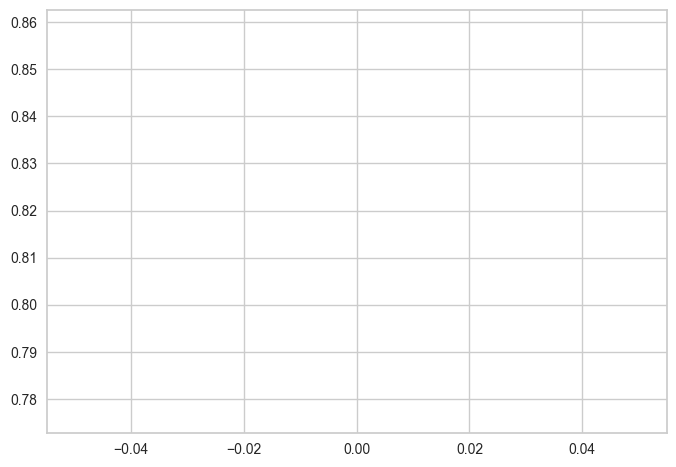

In [20]:
plt.plot(Accuracy_PSO);

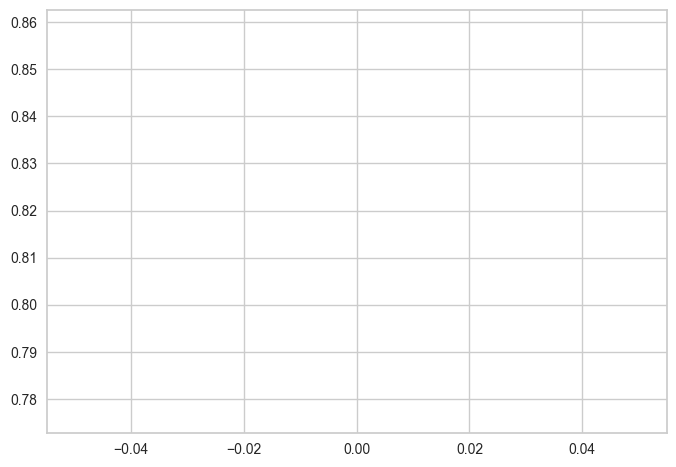

In [21]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_PSO_Accuracy = tracking
plt.plot(tracking)

### F1 Score 

In [22]:
def run_f1_pso(ITERATIONS = 32, POPULATION = 32):
    algorithm = PSO(#pop_size=POPULATION, 
                    #w=0.3, c1=4.0, c2=1.0, 
                    #adaptive=False, initial_velocity='random', 
                    #max_velocity_rate=0.75, pertube_best=False,
                    max_velocity_rate=0.25,
                    pop_size=POPULATION)
    term = get_termination("n_gen", ITERATIONS)

    res = minimize(problemF1,
                algorithm,
                #seed=SEED,
                save_history=True,
                verbose=False,
                output=MyOutput(),
                termination = term)


    index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
    score_best_individual = res.pop.get('F')[index_best_individual]
    parameters_best_individual = res.pop.get('X')[index_best_individual]

    #print(f'Best F1 Score {-score_best_individual}')
    #print(f'Model parameters: \n {parameters_best_individual}')
    return score_best_individual, parameters_best_individual, res

In [23]:
score_best_individual, parameters_best_individual, res = run_f1_pso(ITERATIONS = 1, POPULATION = 1)

C:\Users\Felps\AppData\Local\Temp\ipykernel_26208\2989603633.py:8: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

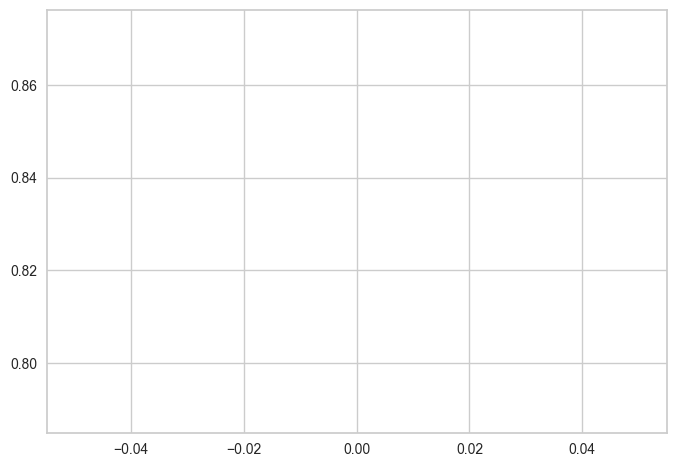

In [24]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 
  
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
F1_PSO = scorelist

plt.plot(scorelist);

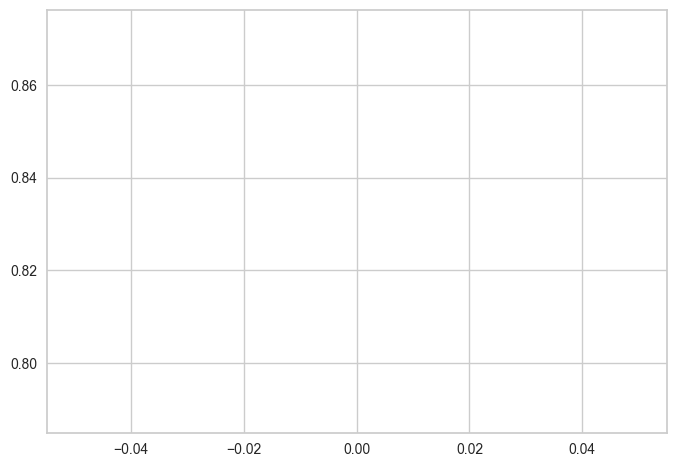

In [25]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_PSO_F1 = tracking
plt.plot(tracking)

### AUC

In [26]:
def run_auc_pso(ITERATIONS = 32, POPULATION = 32):
    algorithm = PSO(#pop_size=POPULATION, 
                    #w=0.3, c1=4.0, c2=1.0, 
                    #adaptive=False, initial_velocity='random', 
                    #max_velocity_rate=0.75, pertube_best=False,
                    max_velocity_rate=0.25,
                    pop_size=POPULATION)
    term = get_termination("n_gen", ITERATIONS)

    res = minimize(problemAUC,
                algorithm,
                #seed=SEED,
                save_history=True,
                verbose=False,
                output=MyOutput(),
                termination = term)


    index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
    score_best_individual = res.pop.get('F')[index_best_individual]
    parameters_best_individual = res.pop.get('X')[index_best_individual]

    #print(f'Best AUC Score {-score_best_individual}')
    #print(f'Model parameters: \n {parameters_best_individual}')
    
    return score_best_individual, parameters_best_individual, res

In [27]:
score_best_individual, parameters_best_individual, res = run_auc_pso(ITERATIONS = 1, POPULATION = 1)

C:\Users\Felps\AppData\Local\Temp\ipykernel_26208\35989252.py:8: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

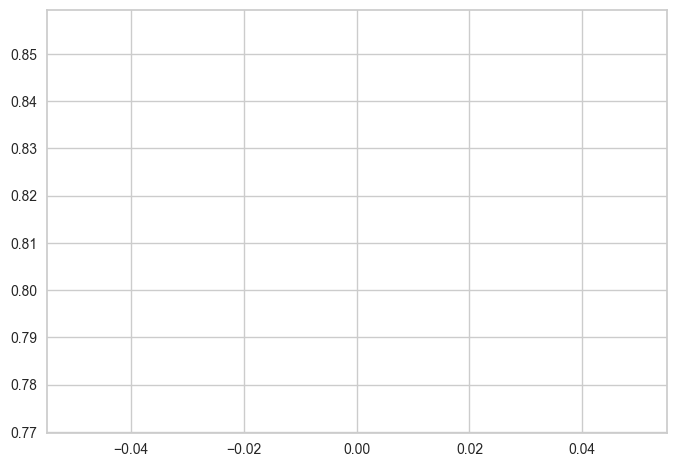

In [28]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 
  
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
AUC_PSO = scorelist

plt.plot(scorelist);

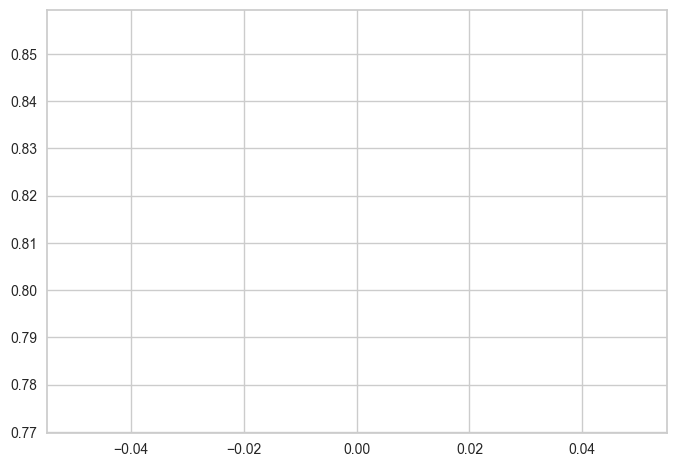

In [29]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_PSO_AUC = tracking
plt.plot(tracking)

## Algoritmo Genético (GA)

### Acurácia

In [30]:
ITERATIONS = 32
POPULATION = 32

In [31]:
from pymoo.algorithms.soo.nonconvex.ga import GA

In [32]:
def run_accuracy_ga(ITERATIONS = 32, POPULATION = 32):

    algorithm = GA(pop_size=POPULATION)

    term = get_termination("n_gen", ITERATIONS)

    res = minimize(problemAccuracy,
                algorithm,
                save_history=True,
                verbose=False,
                output=MyOutput(),
                termination = term)


    index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
    score_best_individual = res.pop.get('F')[index_best_individual]
    parameters_best_individual = res.pop.get('X')[index_best_individual]

    #print(f'Best Accuracy Score {-score_best_individual}')
    #print(f'Model parameters: \n {parameters_best_individual}')
    
    return score_best_individual, parameters_best_individual, res

In [33]:
score_best_individual, parameters_best_individual, res = run_accuracy_ga(ITERATIONS = 1, POPULATION = 1)

C:\Users\Felps\AppData\Local\Temp\ipykernel_26208\1445254303.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

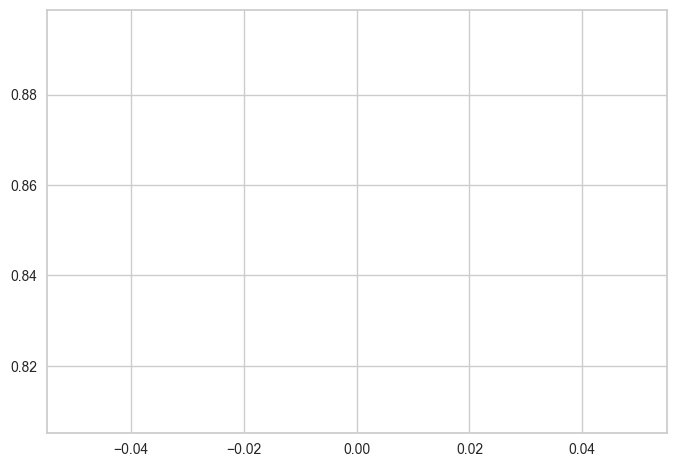

In [34]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_GA_Accuracy = tracking
plt.plot(tracking)

In [35]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 

In [36]:
scorelist = []

for i in range(len(trlist)):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])

In [37]:
Accuracy_GA = scorelist

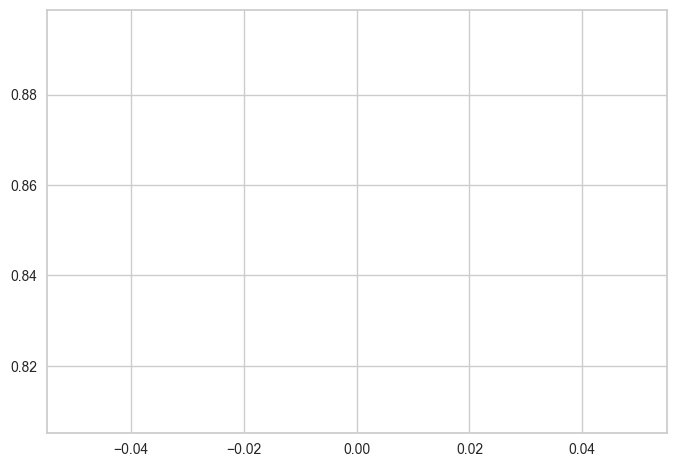

In [38]:
plt.plot(scorelist);

### F1 Score 

In [39]:
from pymoo.algorithms.soo.nonconvex.ga import GA
def run_f1_ga(ITERATIONS = 32, POPULATION = 32):
    algorithm = GA(pop_size=POPULATION)

    term = get_termination("n_gen", ITERATIONS)

    res = minimize(problemF1,
                algorithm,
                save_history=True,
                verbose=False,
                output=MyOutput(),
                termination = term)


    index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
    score_best_individual = res.pop.get('F')[index_best_individual]
    parameters_best_individual = res.pop.get('X')[index_best_individual]

    #print(f'Best F1 Score {-score_best_individual}')
    #print(f'Model parameters: \n {parameters_best_individual}')
    
    return score_best_individual, parameters_best_individual, res

In [40]:
score_best_individual, parameters_best_individual, res = run_f1_ga(ITERATIONS = 1, POPULATION = 1)

C:\Users\Felps\AppData\Local\Temp\ipykernel_26208\1421991478.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

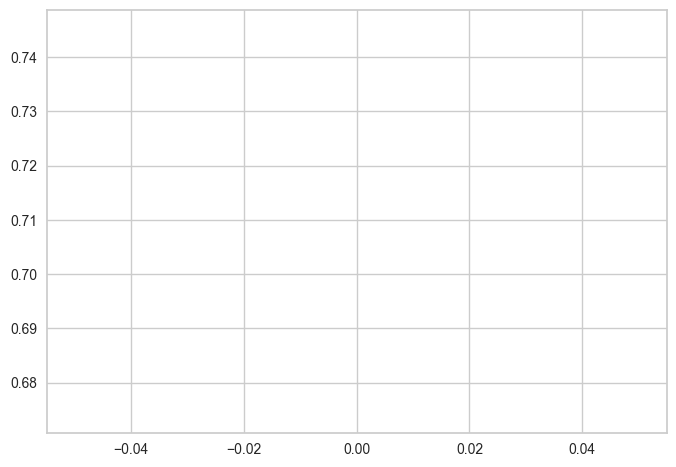

In [41]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 
  
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
F1_GA = scorelist

plt.plot(scorelist);

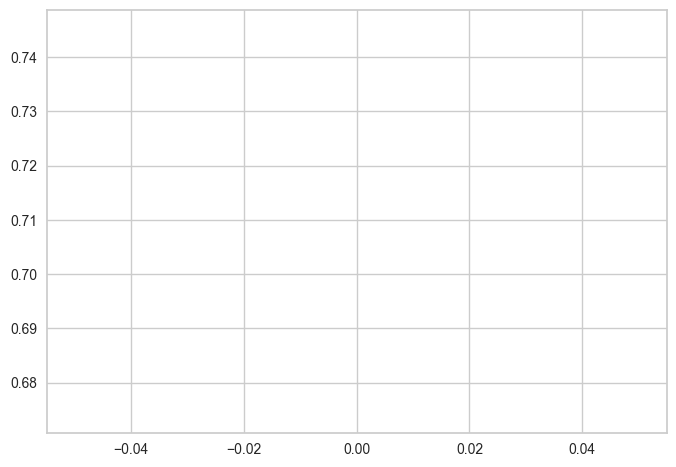

In [42]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_GA_F1 = tracking
plt.plot(tracking)

### AUC

In [43]:
from pymoo.algorithms.soo.nonconvex.ga import GA
def run_auc_ga(ITERATIONS = 32, POPULATION = 32):
    algorithm = GA(pop_size=POPULATION)

    term = get_termination("n_gen", ITERATIONS)

    res = minimize(problemAUC,
                algorithm,
                save_history=True,
                verbose=False,
                output=MyOutput(),
                termination = term)


    index_best_individual = np.where(res.pop.get('F') == np.min(res.pop.get('F')))[0][0]
    score_best_individual = res.pop.get('F')[index_best_individual]
    parameters_best_individual = res.pop.get('X')[index_best_individual]

    #print(f'Best AUC Score {-score_best_individual}')
    #print(f'Model parameters: \n {parameters_best_individual}')
    
    return score_best_individual, parameters_best_individual, res

In [44]:
score_best_individual, parameters_best_individual, res = run_auc_ga(ITERATIONS = 1, POPULATION = 1)

C:\Users\Felps\AppData\Local\Temp\ipykernel_26208\2428158255.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)


  0%|          | 0/32 [00:00<?, ?it/s]

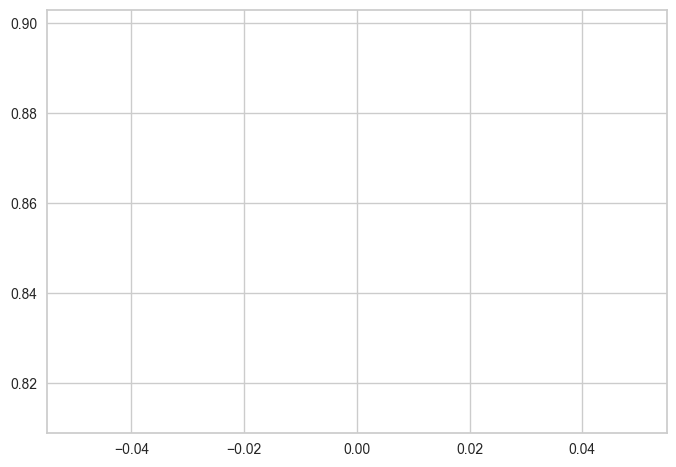

In [45]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 
  
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
AUC_GA = scorelist

plt.plot(scorelist);

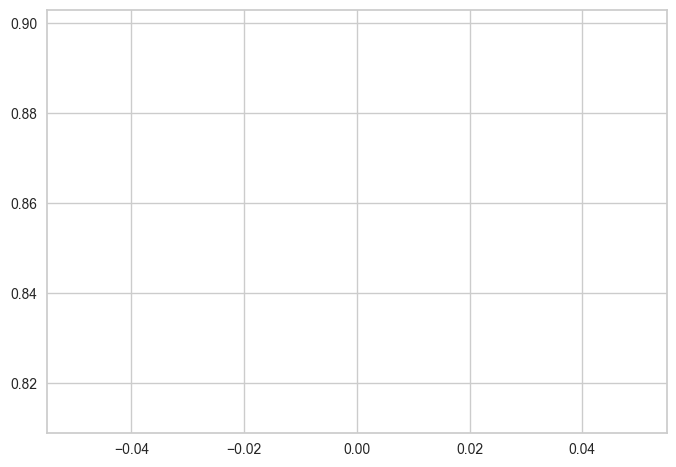

In [46]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_GA_AUC = tracking
plt.plot(tracking)

## Grid Search

### Acurácia

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
n_possibilities = 2

#num_leaves_grid = [i for i in range(num_leaves_min,num_leaves_max, int((num_leaves_max)/13))]
num_leaves_grid = [i for i in map(lambda x: int(x), np.linspace(num_leaves_min, num_leaves_max, n_possibilities))]
num_leaves_grid = num_leaves_grid + [100, 50, 75, 125, 11,150]
#print('Num_Leaves_Grid: ')
#print(num_leaves_grid, len(num_leaves_grid))
#print('\n')


min_child_samples_grid = [i for i in map(lambda x: int(x), np.linspace(min_child_samples_min, min_child_samples_max, n_possibilities))]
#print('min_child_samples_grid:')
#print(min_child_samples_grid, len(min_child_samples_grid))
#print('\n')

n_estimators_grid = [i for i in map(lambda x: int(x), np.linspace(n_estimators_min, n_estimators_max, n_possibilities))]
#print('n_estimators_grid:')
#print(n_estimators_grid, len(n_estimators_grid))
#print('\n')

learning_rate_grid = np.linspace(learning_rate_min, learning_rate_max, n_possibilities)
#print('learning_rate_grid:')
#print(learning_rate_grid, len(learning_rate_grid))
#print('\n')

subsample_for_bin_grid = [i for i in map(lambda x: int(x), np.linspace(subsample_for_bin_min, subsample_for_bin_max, n_possibilities))]
#print('subsample_for_bin_grid:')
#print(subsample_for_bin_grid, len(subsample_for_bin_grid))
#print('\n')

min_split_gain_grid = np.linspace(min_split_gain_min, min_split_gain_max, n_possibilities)
#print('min_split_gain_grid:')
#print(min_split_gain_grid, len(min_split_gain_grid))
#print('\n')

min_child_weight_grid = np.linspace(min_child_weight_min, min_child_weight_max, n_possibilities)
#print('min_child_weight_grid:')
#print(min_child_weight_grid, len(min_child_weight_grid))
#print('\n')

reg_alpha_grid = np.linspace(reg_alpha_min, reg_alpha_max, n_possibilities)
#print('reg_alpha_grid:')
#print(reg_alpha_grid, len(reg_alpha_grid))
#print('\n')


In [49]:
parametros = {'num_leaves': num_leaves_grid, #int
              'min_child_samples': min_child_samples_grid,#int
              'n_estimators': n_estimators_grid, #int
              'learning_rate': learning_rate_grid,
              'subsample_for_bin': subsample_for_bin_grid, # int
              'min_split_gain': min_split_gain_grid,
              'min_child_weight': min_child_weight_grid,
              'reg_alpha': reg_alpha_grid,
              'max_depth': [-1],
              'n_jobs': [-1]}

In [50]:
kfold = KFold(n_splits = 3, shuffle = True)
grid_search = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid = parametros, cv = kfold, n_jobs= -1, verbose = 3)
grid_search.fit(x_fruit, y_fruit)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
#print(melhores_parametros)
#print(melhor_resultado)

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


In [51]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_depth', 'param_min_child_samples', 'param_min_child_weight', 'param_min_split_gain', 'param_n_estimators', 'param_n_jobs', 'param_num_leaves', 'param_reg_alpha', 'param_subsample_for_bin', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [52]:
trlist = grid_search.cv_results_['mean_test_score']

In [53]:
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])

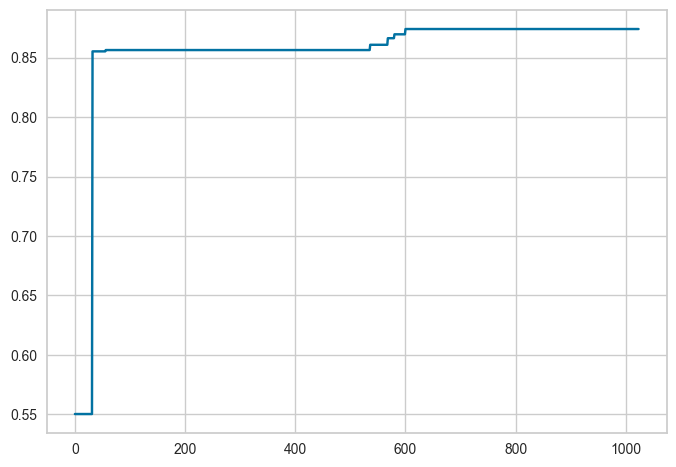

In [54]:
tracking_GS_Accuracy = scorelist
plt.plot(scorelist); 

### F1 Score

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


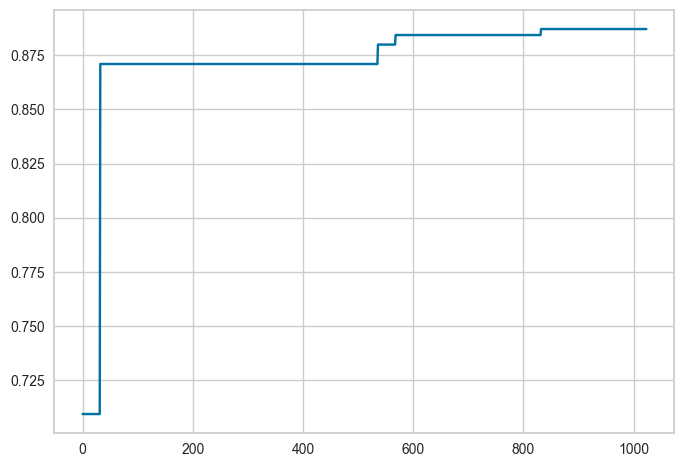

In [55]:
kfold = KFold(n_splits = 3, shuffle = True)
grid_search = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid = parametros, cv = kfold, n_jobs= -1, scoring='f1', verbose = 3)
grid_search.fit(x_fruit, y_fruit)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
#print(melhores_parametros)
#print(melhor_resultado)

trlist = grid_search.cv_results_['mean_test_score']


scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
tracking_GS_F1 = scorelist
plt.plot(scorelist); 

### AUC

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


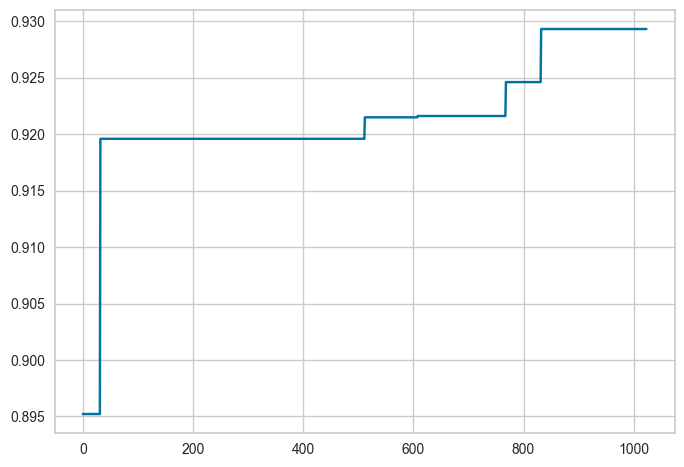

In [56]:
kfold = KFold(n_splits = 3, shuffle = True)
grid_search = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid = parametros, cv = kfold, n_jobs= -1, scoring='roc_auc', verbose = 3)
grid_search.fit(x_fruit, y_fruit)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
#print(melhores_parametros)
#print(melhor_resultado)

trlist = grid_search.cv_results_['mean_test_score']


scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])
    
tracking_GS_AUC = scorelist
plt.plot(scorelist); 

## Optuna

### Acurácia

In [57]:
!pip install optuna

In [58]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import sklearn
from sklearn import datasets
def objective_accuracy(trial):
  
      num_leaves = trial.suggest_int('num_leaves', num_leaves_min, num_leaves_max) #int
      min_child_samples = trial.suggest_int('min_child_samples', min_child_samples_min, min_child_samples_max) #int
      n_estimators      = trial.suggest_int('n_estimators', n_estimators_min, n_estimators_max)#int
      learning_rate     = trial.suggest_float('learning_rate', learning_rate_min, learning_rate_max)
      subsample_for_bin = trial.suggest_int('subsample_for_bin', subsample_for_bin_min, subsample_for_bin_max) #int
      min_split_gain    = trial.suggest_float('min_split_gain', min_split_gain_min, min_split_gain_max)
      min_child_weight  = trial.suggest_float('min_child_weight', min_child_weight_min, min_child_weight_max)
      reg_alpha         = trial.suggest_float('reg_alpha', reg_alpha_min, reg_alpha_max)
      reg_lambda        = trial.suggest_float('reg_lambda', reg_lambda_min, reg_lambda_max)
      max_depth = trial.suggest_int('max_depth', max_depth_min, max_depth_max)
      bagging_fraction = trial.suggest_float('bagging_fraction', bagging_fraction_min, bagging_fraction_max)
      pos_bagging_fraction = trial.suggest_float('pos_bagging_fraction', pos_bagging_fraction_min, pos_bagging_fraction_max)
      neg_bagging_fraction = trial.suggest_float('neg_bagging_fraction', neg_bagging_fraction_min, neg_bagging_fraction_max)
      bagging_freq = trial.suggest_int('bagging_freq', bagging_freq_min, bagging_freq_max)
      feature_fraction = trial.suggest_float('feature_fraction', feature_fraction_min, feature_fraction_max)
      feature_fraction_bynode = trial.suggest_float('feature_fraction_bynode', feature_fraction_bynode_min, feature_fraction_bynode_max)
      extra_trees = trial.suggest_int('extra_trees', extra_trees_min, extra_trees_max)
      #first_metric_only = trial.suggest_int('first_metric_only', first_metric_only_min, first_metric_only_max)
      max_delta_step = trial.suggest_float('max_delta_step', max_delta_step_min, max_delta_step_max)
      linear_lambda = trial.suggest_float('linear_lambda', linear_lambda_min, linear_lambda_max)
      min_data_per_group = trial.suggest_int('min_data_per_group', min_data_per_group_min, min_data_per_group_max)
      max_cat_threshold = trial.suggest_int('max_cat_threshold', max_cat_threshold_min, max_cat_threshold_max)
      cat_l2 = trial.suggest_float('cat_l2', cat_l2_min, cat_l2_max)
      cat_smooth = trial.suggest_float('cat_smooth', cat_smooth_min, cat_smooth_max)
      max_cat_to_onehot = trial.suggest_int('max_cat_to_onehot', max_cat_to_onehot_min, max_cat_to_onehot_max)
      top_k = trial.suggest_int('top_k', top_k_min, top_k_max)

      final_model = lgb.LGBMClassifier(num_leaves       = num_leaves, 
                                      min_child_samples = min_child_samples, 
                                      n_estimators      = n_estimators,
                                      learning_rate     = learning_rate,
                                      subsample_for_bin = subsample_for_bin,
                                      min_split_gain    = min_split_gain,
                                      min_child_weight  = min_child_weight,
                                      reg_alpha         = reg_alpha,
                                      reg_lambda        = reg_lambda,
                                      max_depth= -1,
                                      n_jobs = -1
                                      )
      
      kfold = KFold(n_splits = 3, shuffle = True)

      return sklearn.model_selection.cross_val_score(final_model, x_fruit, y_fruit, n_jobs=-1, cv=kfold).mean()

In [59]:
def run_optuna_accuracy(n_trials=1024):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_accuracy, n_trials=n_trials, n_jobs = -1)
    trial = study.best_trial
    #print('Accuracy: {}'.format(trial.value))
    #print("Best hyperparameters: {}".format(trial.params))
    return trial.value, study


In [60]:
trial, study = run_optuna_accuracy(1)

In [61]:
trial

0.8176534436352701

In [62]:
tracking = []
for i in range(len(study.trials)):
  if i == 0: 
    tracking.append(study.trials[i].value)
  elif tracking[i-1] > study.trials[i].value:
    tracking.append(tracking[i-1])
  else:
    tracking.append(study.trials[i].value)
#tracking_sorted = sorted(tracking)

In [63]:
tracking_Optuna_Accuracy = tracking

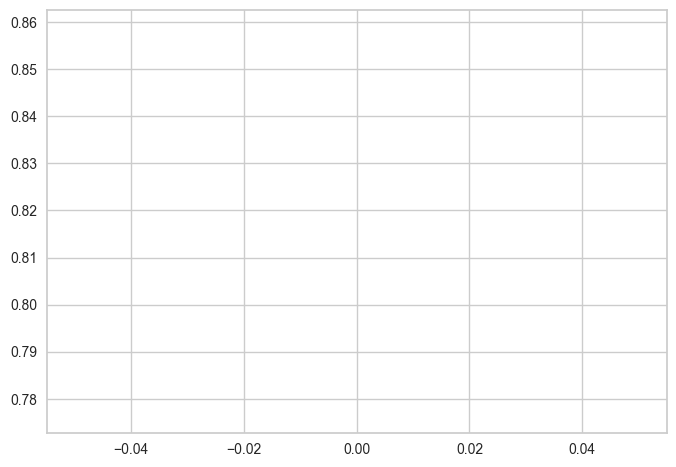

In [64]:
plt.plot(tracking);
#plt.plot(tracking_sorted) 

In [65]:
#optuna.visualization.plot_optimization_history(study)

In [66]:
#optuna.visualization.plot_slice(study)

### F1 Score

In [67]:
def objective_f1(trial):
  
      num_leaves = trial.suggest_int('num_leaves', num_leaves_min, num_leaves_max) #int
      min_child_samples = trial.suggest_int('min_child_samples', min_child_samples_min, min_child_samples_max) #int
      n_estimators      = trial.suggest_int('n_estimators', n_estimators_min, n_estimators_max)#int
      learning_rate     = trial.suggest_float('learning_rate', learning_rate_min, learning_rate_max)
      subsample_for_bin = trial.suggest_int('subsample_for_bin', subsample_for_bin_min, subsample_for_bin_max) #int
      min_split_gain    = trial.suggest_float('min_split_gain', min_split_gain_min, min_split_gain_max)
      min_child_weight  = trial.suggest_float('min_child_weight', min_child_weight_min, min_child_weight_max)
      reg_alpha         = trial.suggest_float('reg_alpha', reg_alpha_min, reg_alpha_max)
      reg_lambda        = trial.suggest_float('reg_lambda', reg_lambda_min, reg_lambda_max)
      max_depth = trial.suggest_int('max_depth', max_depth_min, max_depth_max)
      bagging_fraction = trial.suggest_float('bagging_fraction', bagging_fraction_min, bagging_fraction_max)
      pos_bagging_fraction = trial.suggest_float('pos_bagging_fraction', pos_bagging_fraction_min, pos_bagging_fraction_max)
      neg_bagging_fraction = trial.suggest_float('neg_bagging_fraction', neg_bagging_fraction_min, neg_bagging_fraction_max)
      bagging_freq = trial.suggest_int('bagging_freq', bagging_freq_min, bagging_freq_max)
      feature_fraction = trial.suggest_float('feature_fraction', feature_fraction_min, feature_fraction_max)
      feature_fraction_bynode = trial.suggest_float('feature_fraction_bynode', feature_fraction_bynode_min, feature_fraction_bynode_max)
      extra_trees = trial.suggest_int('extra_trees', extra_trees_min, extra_trees_max)
      #first_metric_only = trial.suggest_int('first_metric_only', first_metric_only_min, first_metric_only_max)
      max_delta_step = trial.suggest_float('max_delta_step', max_delta_step_min, max_delta_step_max)
      linear_lambda = trial.suggest_float('linear_lambda', linear_lambda_min, linear_lambda_max)
      min_data_per_group = trial.suggest_int('min_data_per_group', min_data_per_group_min, min_data_per_group_max)
      max_cat_threshold = trial.suggest_int('max_cat_threshold', max_cat_threshold_min, max_cat_threshold_max)
      cat_l2 = trial.suggest_float('cat_l2', cat_l2_min, cat_l2_max)
      cat_smooth = trial.suggest_float('cat_smooth', cat_smooth_min, cat_smooth_max)
      max_cat_to_onehot = trial.suggest_int('max_cat_to_onehot', max_cat_to_onehot_min, max_cat_to_onehot_max)
      top_k = trial.suggest_int('top_k', top_k_min, top_k_max)

      final_model = lgb.LGBMClassifier(num_leaves       = num_leaves, 
                                      min_child_samples = min_child_samples, 
                                      n_estimators      = n_estimators,
                                      learning_rate     = learning_rate,
                                      subsample_for_bin = subsample_for_bin,
                                      min_split_gain    = min_split_gain,
                                      min_child_weight  = min_child_weight,
                                      reg_alpha         = reg_alpha,
                                      reg_lambda        = reg_lambda,
                                      max_depth= -1,
                                      n_jobs = -1
                                      )
      
      kfold = KFold(n_splits = 3, shuffle = True)

      return sklearn.model_selection.cross_val_score(final_model, x_fruit, y_fruit, n_jobs=-1, scoring='f1', cv=kfold).mean()

In [68]:
def run_optuna_f1(n_trials=1024):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_f1, n_trials=n_trials, n_jobs = -1)
    trial = study.best_trial
    #print('F1: {}'.format(trial.value))
    #print("Best hyperparameters: {}".format(trial.params))
    return trial.value, study

In [69]:
trial, study = run_optuna_f1(1)

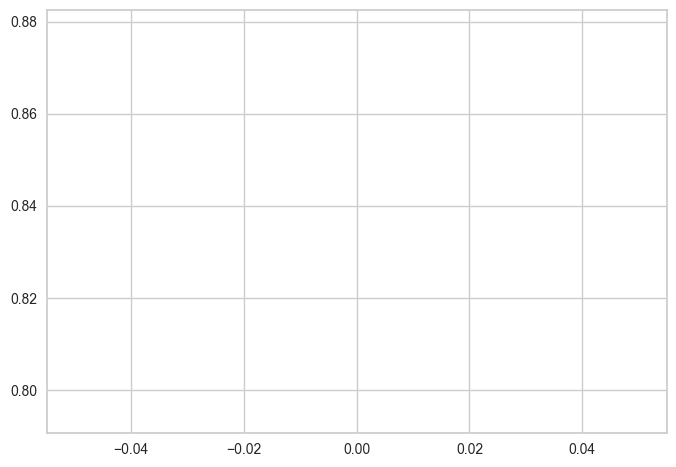

In [70]:
tracking = []
for i in range(len(study.trials)):
  if i == 0: 
    tracking.append(study.trials[i].value)
  elif tracking[i-1] > study.trials[i].value:
    tracking.append(tracking[i-1])
  else:
    tracking.append(study.trials[i].value)
#tracking_sorted = sorted(tracking)

tracking_Optuna_F1 = tracking

plt.plot(tracking);
#plt.plot(tracking_sorted) 

### AUC

In [71]:
def objective_auc(trial):
  
      num_leaves = trial.suggest_int('num_leaves', num_leaves_min, num_leaves_max) #int
      min_child_samples = trial.suggest_int('min_child_samples', min_child_samples_min, min_child_samples_max) #int
      n_estimators      = trial.suggest_int('n_estimators', n_estimators_min, n_estimators_max)#int
      learning_rate     = trial.suggest_float('learning_rate', learning_rate_min, learning_rate_max)
      subsample_for_bin = trial.suggest_int('subsample_for_bin', subsample_for_bin_min, subsample_for_bin_max) #int
      min_split_gain    = trial.suggest_float('min_split_gain', min_split_gain_min, min_split_gain_max)
      min_child_weight  = trial.suggest_float('min_child_weight', min_child_weight_min, min_child_weight_max)
      reg_alpha         = trial.suggest_float('reg_alpha', reg_alpha_min, reg_alpha_max)
      reg_lambda        = trial.suggest_float('reg_lambda', reg_lambda_min, reg_lambda_max)
      max_depth = trial.suggest_int('max_depth', max_depth_min, max_depth_max)
      bagging_fraction = trial.suggest_float('bagging_fraction', bagging_fraction_min, bagging_fraction_max)
      pos_bagging_fraction = trial.suggest_float('pos_bagging_fraction', pos_bagging_fraction_min, pos_bagging_fraction_max)
      neg_bagging_fraction = trial.suggest_float('neg_bagging_fraction', neg_bagging_fraction_min, neg_bagging_fraction_max)
      bagging_freq = trial.suggest_int('bagging_freq', bagging_freq_min, bagging_freq_max)
      feature_fraction = trial.suggest_float('feature_fraction', feature_fraction_min, feature_fraction_max)
      feature_fraction_bynode = trial.suggest_float('feature_fraction_bynode', feature_fraction_bynode_min, feature_fraction_bynode_max)
      extra_trees = trial.suggest_int('extra_trees', extra_trees_min, extra_trees_max)
      #first_metric_only = trial.suggest_int('first_metric_only', first_metric_only_min, first_metric_only_max)
      max_delta_step = trial.suggest_float('max_delta_step', max_delta_step_min, max_delta_step_max)
      linear_lambda = trial.suggest_float('linear_lambda', linear_lambda_min, linear_lambda_max)
      min_data_per_group = trial.suggest_int('min_data_per_group', min_data_per_group_min, min_data_per_group_max)
      max_cat_threshold = trial.suggest_int('max_cat_threshold', max_cat_threshold_min, max_cat_threshold_max)
      cat_l2 = trial.suggest_float('cat_l2', cat_l2_min, cat_l2_max)
      cat_smooth = trial.suggest_float('cat_smooth', cat_smooth_min, cat_smooth_max)
      max_cat_to_onehot = trial.suggest_int('max_cat_to_onehot', max_cat_to_onehot_min, max_cat_to_onehot_max)
      top_k = trial.suggest_int('top_k', top_k_min, top_k_max)

      final_model = lgb.LGBMClassifier(num_leaves       = num_leaves, 
                                      min_child_samples = min_child_samples, 
                                      n_estimators      = n_estimators,
                                      learning_rate     = learning_rate,
                                      subsample_for_bin = subsample_for_bin,
                                      min_split_gain    = min_split_gain,
                                      min_child_weight  = min_child_weight,
                                      reg_alpha         = reg_alpha,
                                      reg_lambda        = reg_lambda,
                                      max_depth= -1,
                                      n_jobs = -1
                                      )
      
      kfold = KFold(n_splits = 3, shuffle = True)

      return sklearn.model_selection.cross_val_score(final_model, x_fruit, y_fruit, n_jobs=-1, scoring='roc_auc', cv=kfold).mean()

In [72]:
def run_optuna_auc(n_trials=1024):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_auc, n_trials=n_trials, n_jobs = -1)
    trial = study.best_trial
    #print('AUC: {}'.format(trial.value))
    #print("Best hyperparameters: {}".format(trial.params))
    return trial.value, study

In [73]:
trial, study = run_optuna_auc(1)

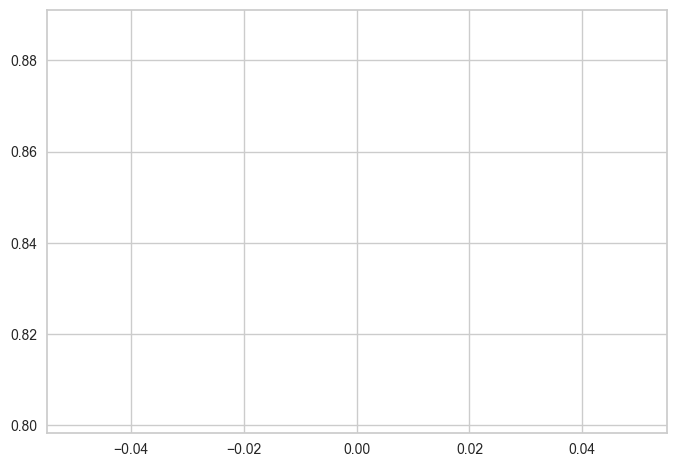

In [74]:
tracking = []
for i in range(len(study.trials)):
  if i == 0: 
    tracking.append(study.trials[i].value)
  elif tracking[i-1] > study.trials[i].value:
    tracking.append(tracking[i-1])
  else:
    tracking.append(study.trials[i].value)
#tracking_sorted = sorted(tracking)

tracking_Optuna_AUC = tracking

plt.plot(tracking);
#plt.plot(tracking_sorted) 

# Análise Comparativa

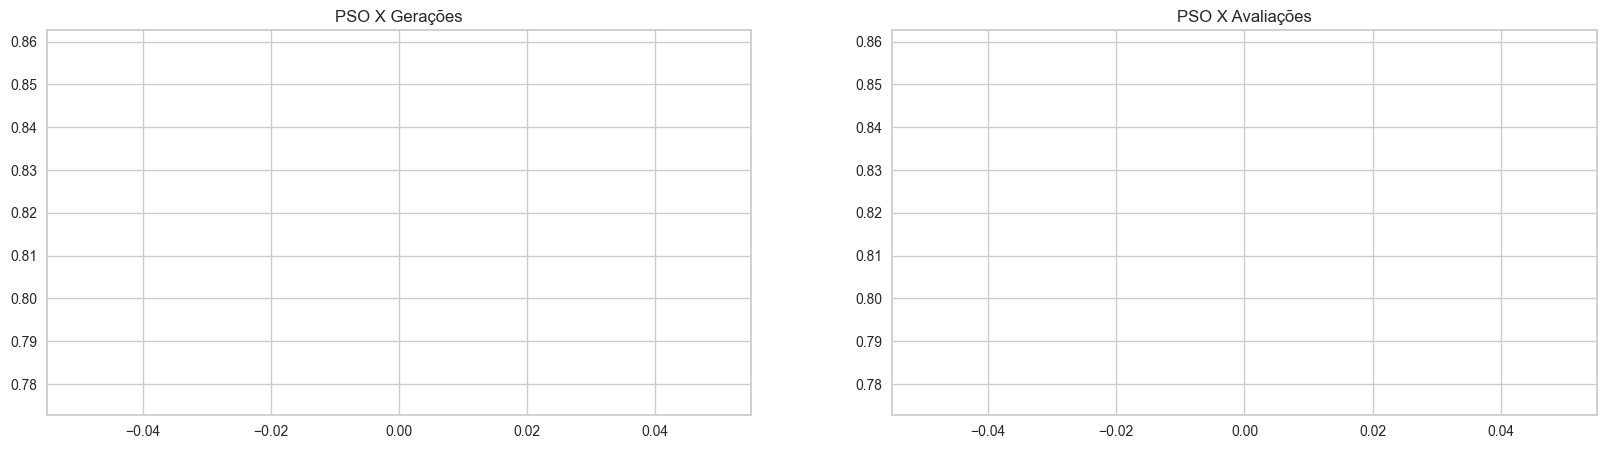

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.set_title('PSO X Gerações')
ax2.set_title('PSO X Avaliações')

ax1.plot(tracking_PSO_Accuracy)
ax2.plot(Accuracy_PSO)
plt.show()

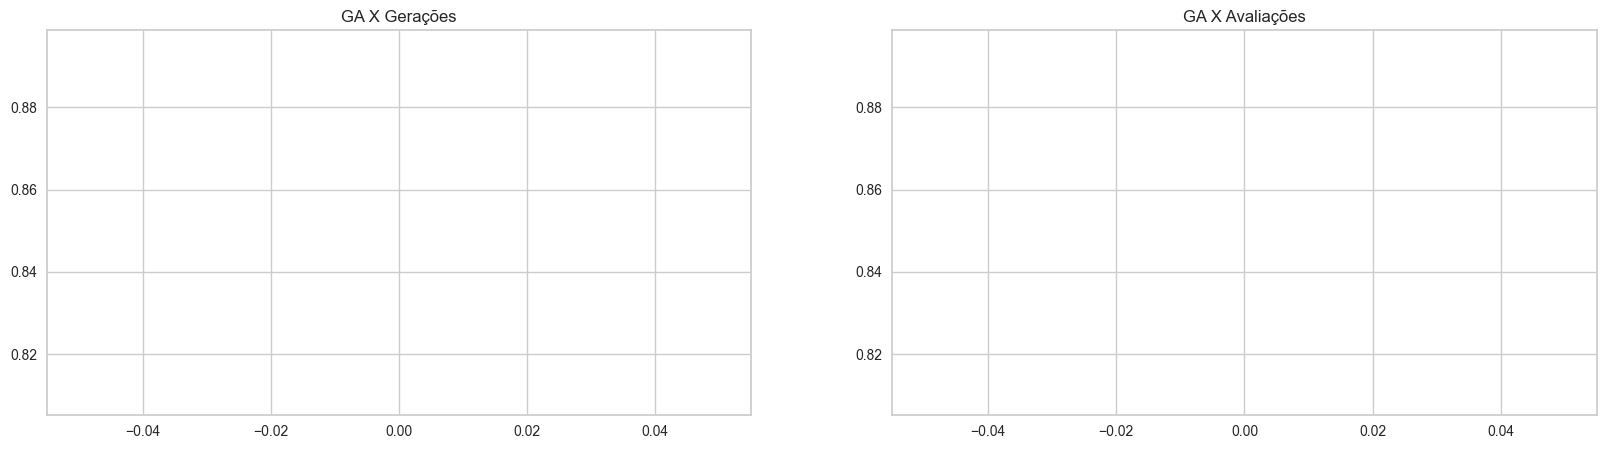

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.set_title('GA X Gerações')
ax2.set_title('GA X Avaliações')

ax1.plot(tracking_GA_Accuracy)
ax2.plot(Accuracy_GA)
plt.show()

Gráficos Comparativos Acurácia

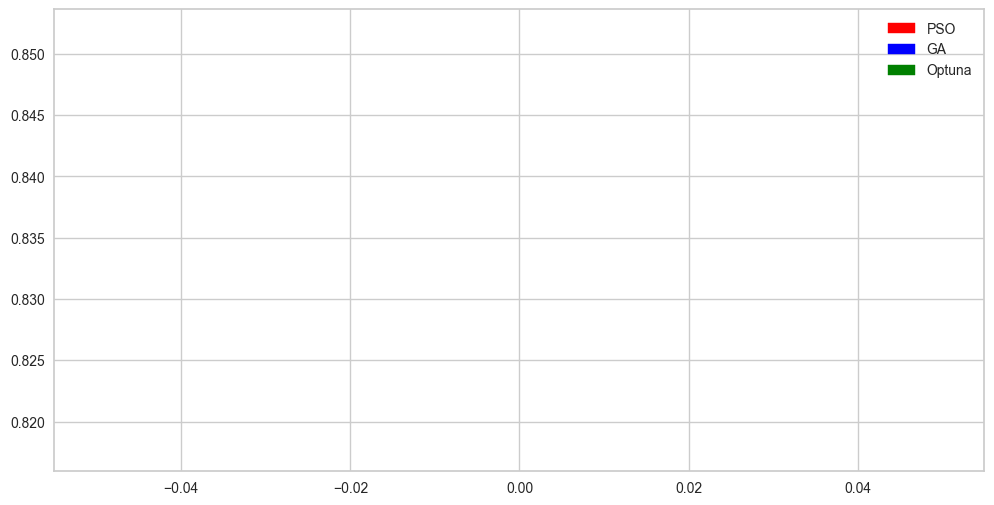

In [77]:
from IPython.core.pylabtools import figsize
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 6))
red_patch = mpatches.Patch(color='red', label='PSO')
blue_patch = mpatches.Patch(color='blue', label='GA')
green_patch = mpatches.Patch(color='green', label='Optuna')
#black_patch = mpatches.Patch(color='black', label='GridSearch')

plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.plot(Accuracy_GA, color = 'blue', linewidth=1, linestyle='-', )
plt.plot(Accuracy_PSO, color = 'red', linewidth=1, linestyle='-')
plt.plot(tracking_Optuna_Accuracy, color = 'green', linewidth=1, linestyle='-')
#plt.plot(tracking_GS, color = 'black', linewidth=3, linestyle='-')
plt.show()

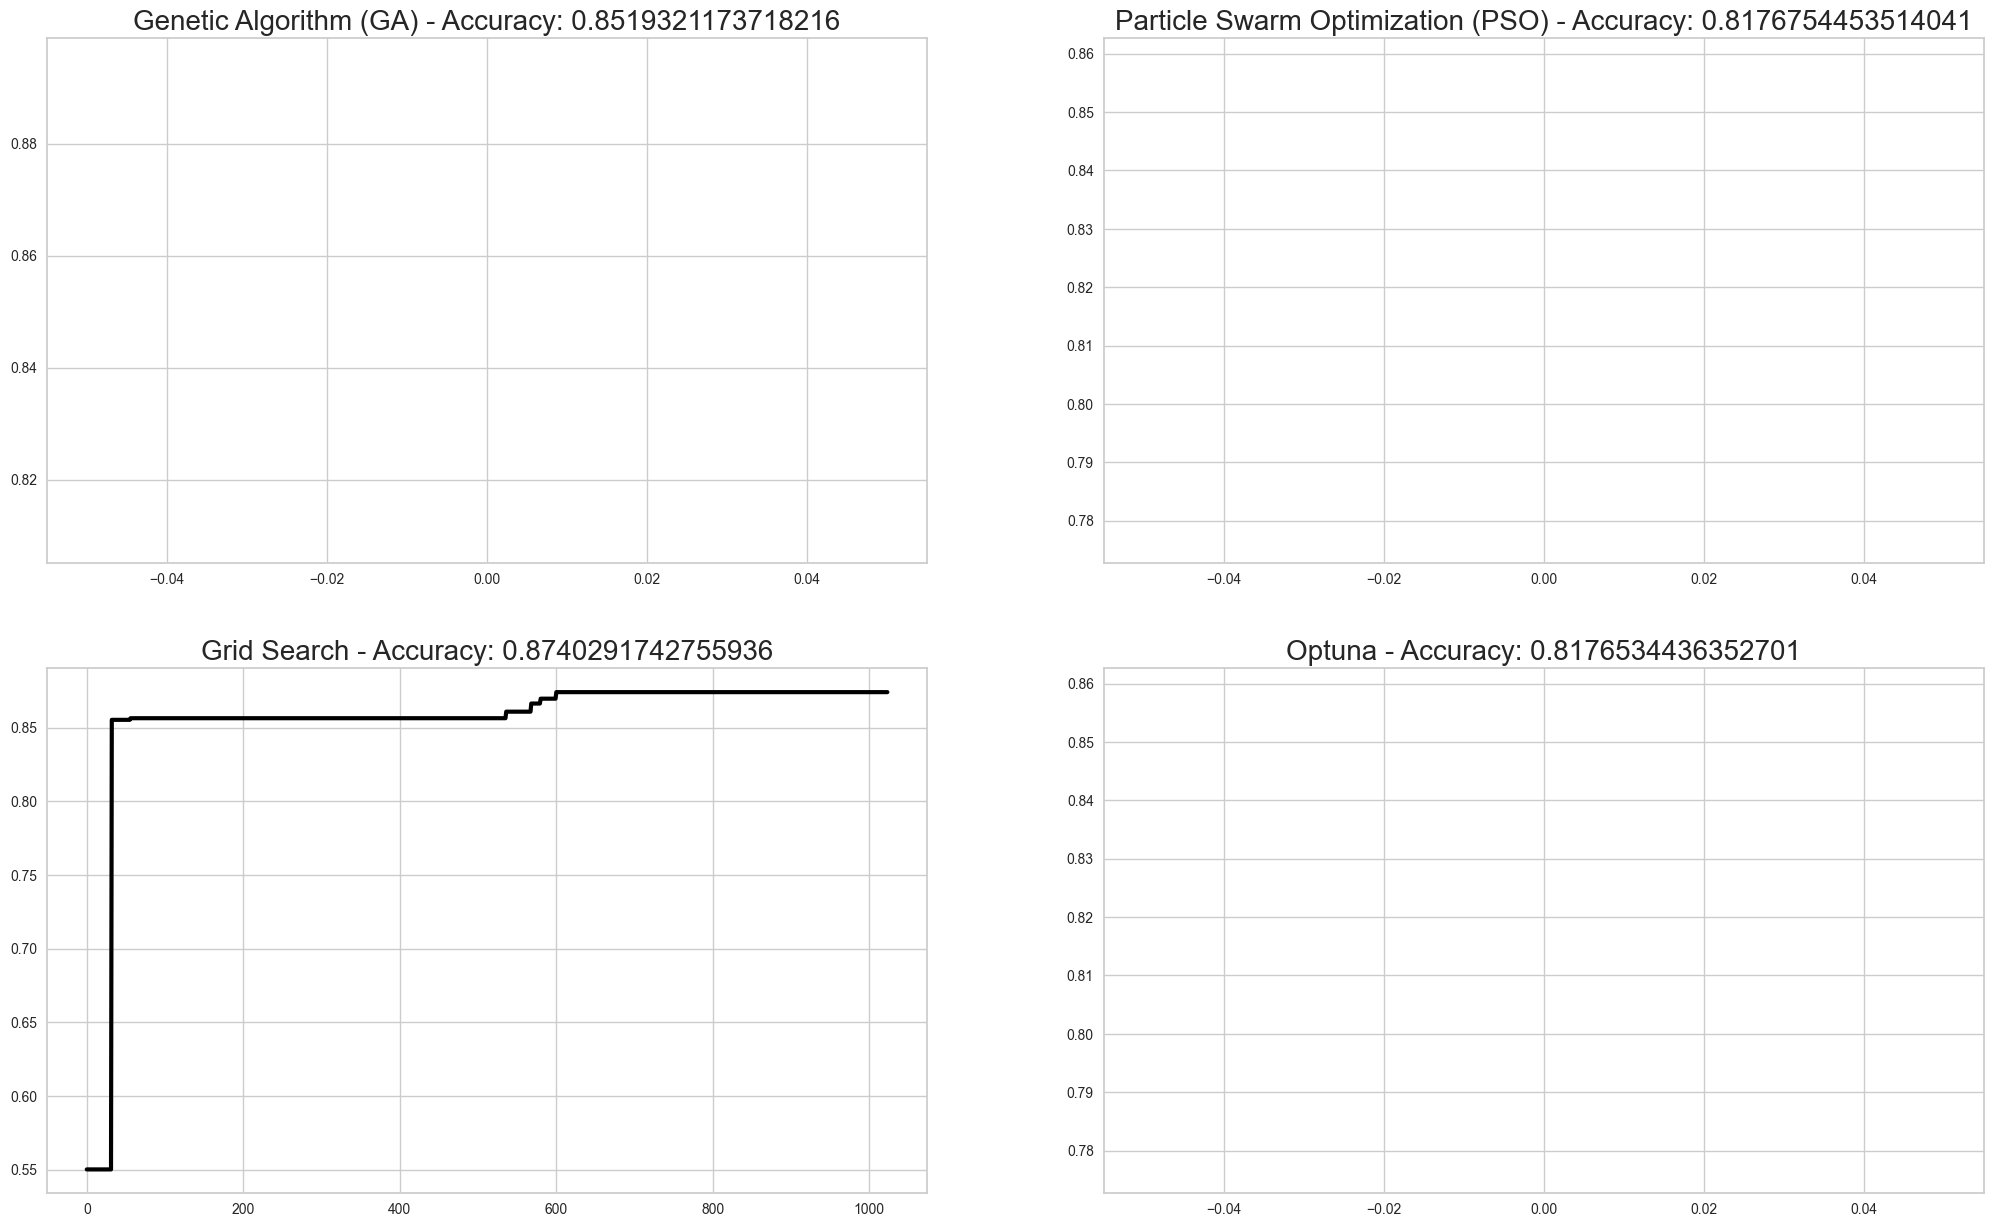

In [78]:
fig, ax = plt.subplots(2, 2, figsize=(25,15))

ax[0, 0].set_title(f'Genetic Algorithm (GA) - Accuracy: {max(tracking_GA_Accuracy)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[0, 1].set_title(f'Particle Swarm Optimization (PSO) - Accuracy: {max(tracking_PSO_Accuracy)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[1, 0].set_title(f'Grid Search - Accuracy: {max(tracking_GS_Accuracy)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[1, 1].set_title(f'Optuna - Accuracy: {max(tracking_Optuna_Accuracy)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[0,0].plot(tracking_GA_Accuracy, color = 'blue', linewidth=3, linestyle='-', )
ax[0,1].plot(tracking_PSO_Accuracy, color = 'red', linewidth=3, linestyle='-')

ax[1,0].plot(tracking_GS_Accuracy, color = 'black', linewidth=3, linestyle='-')
ax[1,1].plot(tracking_Optuna_Accuracy, color = 'green', linewidth=3, linestyle='-')


F1 score

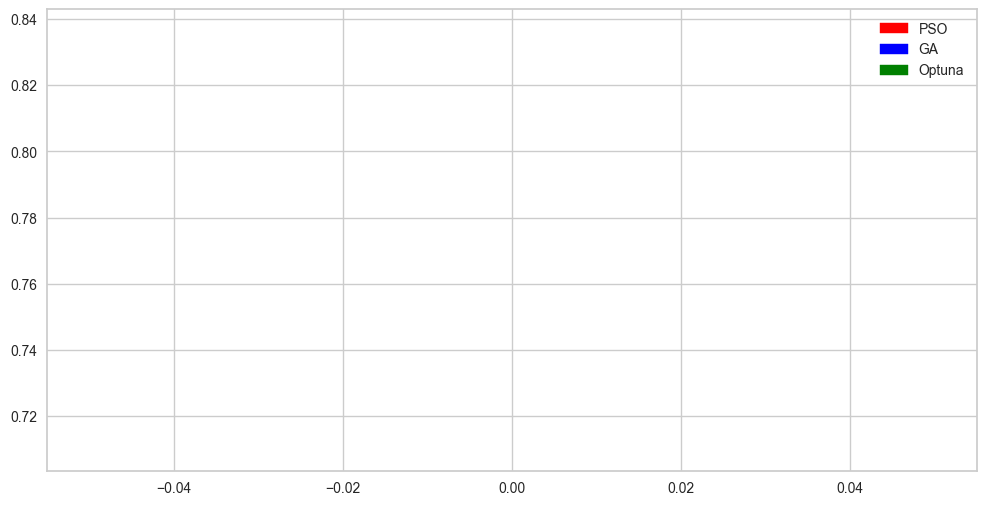

In [79]:
plt.figure(figsize=(12, 6))
red_patch = mpatches.Patch(color='red', label='PSO')
blue_patch = mpatches.Patch(color='blue', label='GA')
green_patch = mpatches.Patch(color='green', label='Optuna')
#black_patch = mpatches.Patch(color='black', label='GridSearch')

plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.plot(F1_GA, color = 'blue', linewidth=1, linestyle='-', )
plt.plot(F1_PSO, color = 'red', linewidth=1, linestyle='-')
plt.plot(tracking_Optuna_F1, color = 'green', linewidth=1, linestyle='-')
#plt.plot(tracking_GS, color = 'black', linewidth=3, linestyle='-')
plt.show()

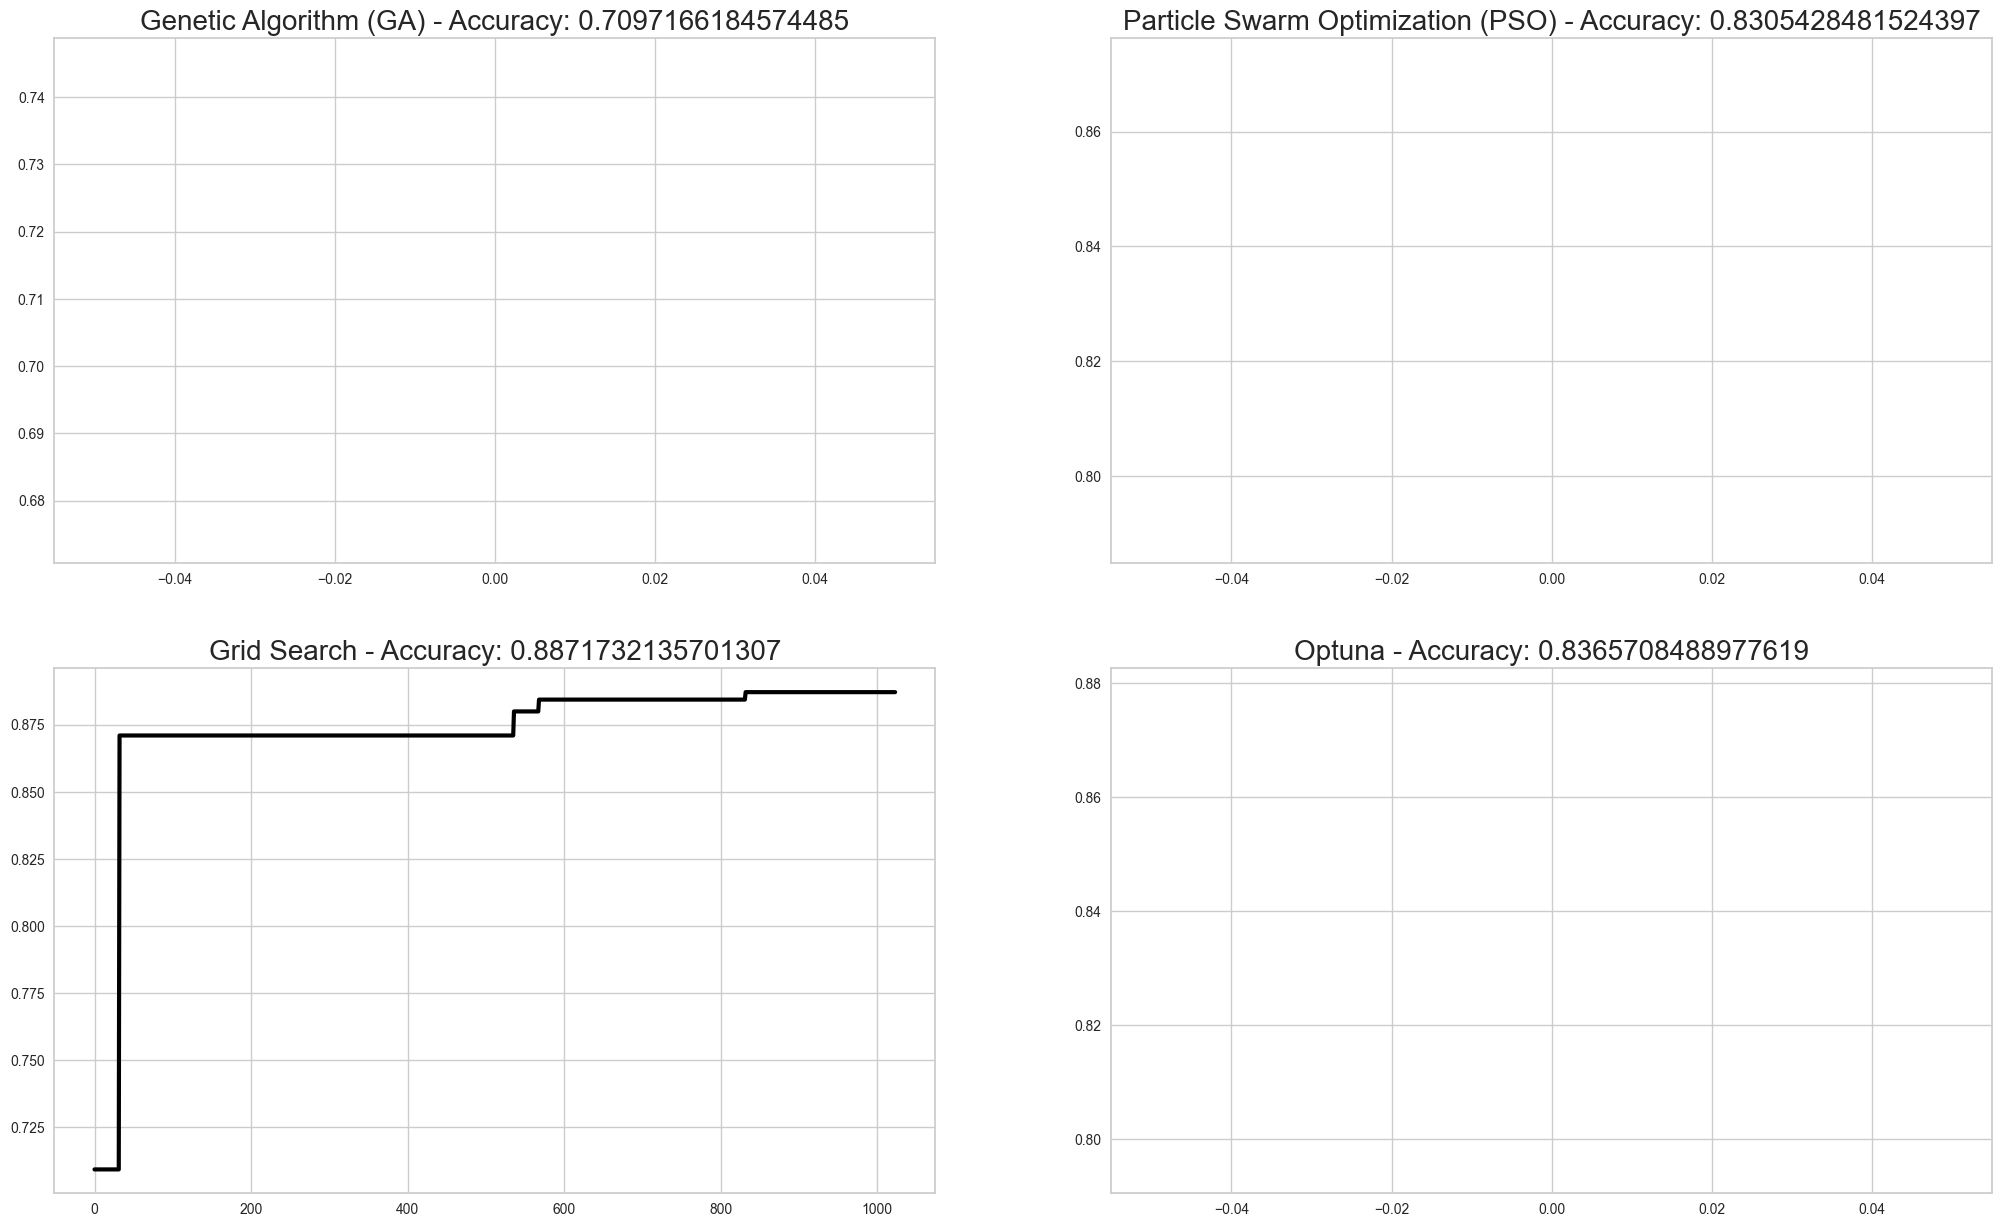

In [80]:
fig, ax = plt.subplots(2, 2, figsize=(25,15))

ax[0, 0].set_title(f'Genetic Algorithm (GA) - Accuracy: {max(tracking_GA_F1)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[0, 1].set_title(f'Particle Swarm Optimization (PSO) - Accuracy: {max(tracking_PSO_F1)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[1, 0].set_title(f'Grid Search - Accuracy: {max(tracking_GS_F1)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[1, 1].set_title(f'Optuna - Accuracy: {max(tracking_Optuna_F1)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[0,0].plot(tracking_GA_F1, color = 'blue', linewidth=3, linestyle='-', )
ax[0,1].plot(tracking_PSO_F1, color = 'red', linewidth=3, linestyle='-')

ax[1,0].plot(tracking_GS_F1, color = 'black', linewidth=3, linestyle='-')
ax[1,1].plot(tracking_Optuna_F1, color = 'green', linewidth=3, linestyle='-')


ROC AUC

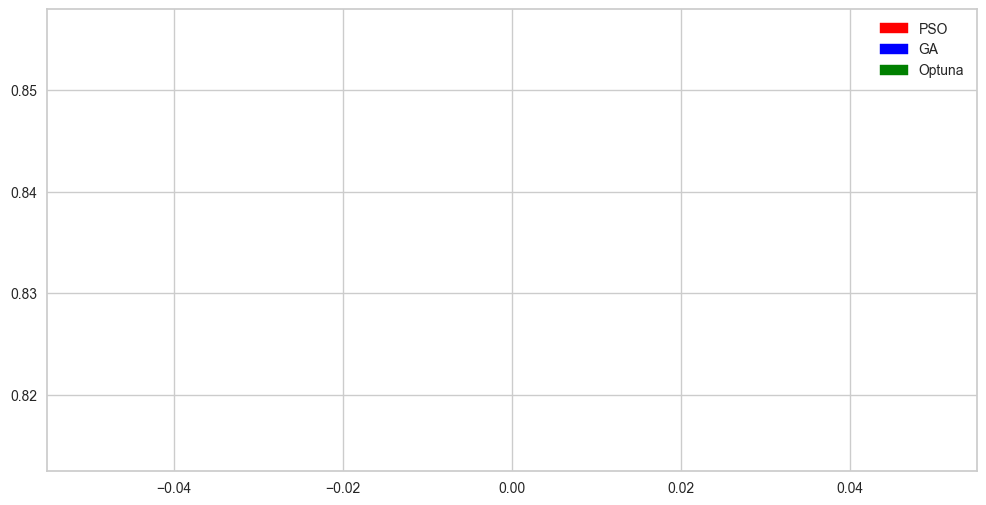

In [81]:
plt.figure(figsize=(12, 6))
red_patch = mpatches.Patch(color='red', label='PSO')
blue_patch = mpatches.Patch(color='blue', label='GA')
green_patch = mpatches.Patch(color='green', label='Optuna')
#black_patch = mpatches.Patch(color='black', label='GridSearch')

plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.plot(AUC_GA, color = 'blue', linewidth=1, linestyle='-', )
plt.plot(AUC_PSO, color = 'red', linewidth=1, linestyle='-')
plt.plot(tracking_Optuna_AUC, color = 'green', linewidth=1, linestyle='-')
#plt.plot(tracking_GS, color = 'black', linewidth=3, linestyle='-')
plt.show()

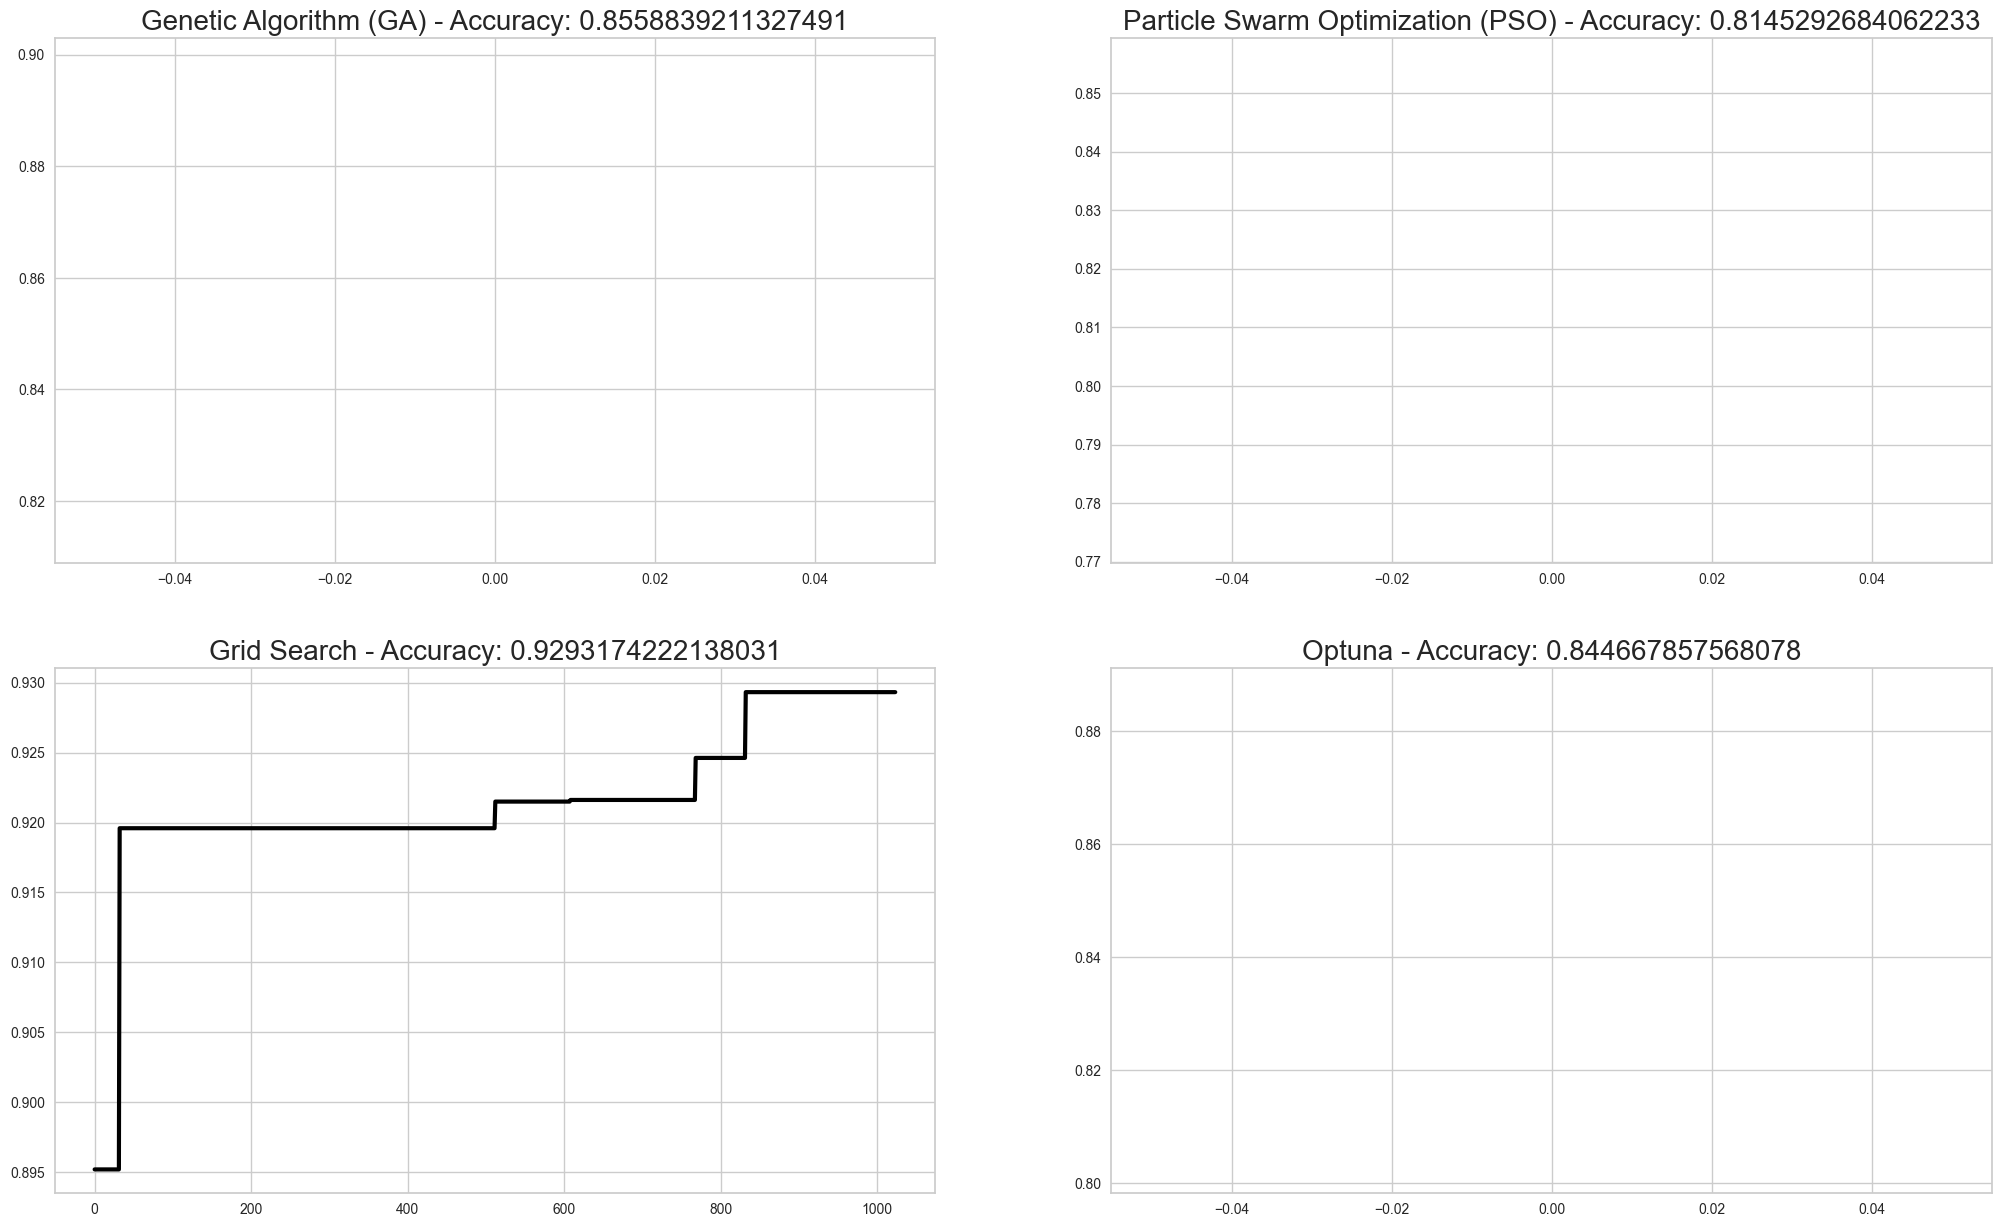

In [82]:
fig, ax = plt.subplots(2, 2, figsize=(25,15))

ax[0, 0].set_title(f'Genetic Algorithm (GA) - Accuracy: {max(tracking_GA_AUC)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[0, 1].set_title(f'Particle Swarm Optimization (PSO) - Accuracy: {max(tracking_PSO_AUC)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[1, 0].set_title(f'Grid Search - Accuracy: {max(tracking_GS_AUC)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[1, 1].set_title(f'Optuna - Accuracy: {max(tracking_Optuna_AUC)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[0,0].plot(tracking_GA_AUC, color = 'blue', linewidth=3, linestyle='-', )
ax[0,1].plot(tracking_PSO_AUC, color = 'red', linewidth=3, linestyle='-')

ax[1,0].plot(tracking_GS_AUC, color = 'black', linewidth=3, linestyle='-')
ax[1,1].plot(tracking_Optuna_AUC, color = 'green', linewidth=3, linestyle='-')


# Gerando Dados Para Análise 

In [84]:
from tqdm import tqdm
import pandas as pd
from os import system

filename = './lightGBM_fruit_data.csv'

try:
    lightGBM_data = pd.read_csv(filename)
except:
    open(filename, "a")
    lightGBM_data = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'F1', 'AUC'])


for i in tqdm(range(30)):
    accuracy_pso, _, _ = run_accuracy_pso()
    f1_pso, _, _ = run_f1_pso()
    auc_pso, _, _ = run_auc_pso()
    temp = pd.DataFrame({'Algorithm' : ['PSO'], 
                         'Accuracy' :[-accuracy_pso[0]], 
                         'F1' : [-f1_pso[0]], 
                         'AUC' : [-auc_pso[0]]})
    #lightGBM_data = lightGBM_data.append(temp, ignore_index = True)
    lightGBM_data = pd.concat([lightGBM_data, temp], ignore_index=True)
    lightGBM_data[['Algorithm', 'Accuracy', 'F1', 'AUC']].to_csv(filename)
    
    accuracy_ga, _, _ = run_accuracy_ga()
    f1_ga, _, _ = run_f1_ga()
    auc_ga, _, _ = run_auc_ga()
    temp = pd.DataFrame({'Algorithm' : ['GA'], 
                         'Accuracy' :[-accuracy_ga[0]], 
                         'F1' : [-f1_ga[0]], 
                         'AUC' : [-auc_ga[0]]})
    #lightGBM_data = lightGBM_data.append(temp, ignore_index = True)
    lightGBM_data = pd.concat([lightGBM_data, temp], ignore_index=True)
    lightGBM_data[['Algorithm', 'Accuracy', 'F1', 'AUC']].to_csv(filename)
    
    accuracy_optuna, _ = run_optuna_accuracy()
    f1_optuna, _ = run_optuna_f1()
    auc_optuna, _ = run_optuna_auc()
    temp = pd.DataFrame({'Algorithm' : ['Optuna'], 
                         'Accuracy' :[accuracy_optuna], 
                         'F1' : [f1_optuna], 
                         'AUC' : [auc_optuna]})
    #lightGBM_data = lightGBM_data.append(temp, ignore_index = True)
    lightGBM_data = pd.concat([lightGBM_data, temp], ignore_index=True)
    lightGBM_data[['Algorithm', 'Accuracy', 'F1', 'AUC']].to_csv(filename)

  0%|          | 0/30 [00:00<?, ?it/s]C:\Users\Felps\AppData\Local\Temp\ipykernel_26208\2759410085.py:8: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)

  0%|          | 0/32 [00:33<?, ?it/s]

  0%|          | 0/32 [00:21<?, ?it/s]
C:\Users\Felps\AppData\Local\Temp\ipykernel_26208\1445254303.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)
  0%|          | 0/32 [00:17<?, ?it/s]

  3%|▎         | 1/30 [14:12<6:51:57, 852.33s/it]C:\Users\Felps\AppData\Local\Temp\ipykernel_26208\2759410085.py:8: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  term = get_termination("n_gen", ITERATIONS)

  0%|          | 0/32

In [ ]:
lightGBM_data.to_csv(filename)